In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Imports and Seed Setting**

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import csv
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.metrics import mean_squared_error

# Set seed for reproducibility
SEED = 2020815
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)


# **Device Determination and Plotting Functions**

In [3]:
def determine_device():
    '''Choose the device for computations (GPU if available, otherwise CPU)'''
    return 'cuda' if torch.cuda.is_available() else 'cpu'

def plot_training_progress(loss_records, title=''):
    '''Visualize training and validation losses'''
    num_steps = len(loss_records['train'])
    x_train = range(num_steps)
    x_dev = x_train[::num_steps // len(loss_records['dev'])]

    figure(figsize=(6, 4))
    plt.plot(x_train, loss_records['train'], color='red', label='Training Loss')
    plt.plot(x_dev, loss_records['dev'], color='cyan', label='Validation Loss')
    plt.ylim(0.0, 5.0)
    plt.xlabel('Epochs')
    plt.ylabel('Mean Squared Error')
    plt.title(f'Training Progress: {title}')
    plt.legend()
    plt.show()

def visualize_predictions(dataset, model, device, limit=35.0, predictions=None, ground_truths=None):
    '''Plot predictions vs actual values'''
    if predictions is None or ground_truths is None:
        model.eval()
        predictions, ground_truths = [], []
        for data, target in dataset:
            data, target = data.to(device), target.to(device)
            with torch.no_grad():
                pred = model(data)
                predictions.append(pred.cpu())
                ground_truths.append(target.cpu())
        predictions = torch.cat(predictions, dim=0).numpy()
        ground_truths = torch.cat(ground_truths, dim=0).numpy()

    figure(figsize=(5, 5))
    plt.scatter(ground_truths, predictions, color='red', alpha=0.5)
    plt.plot([0, limit], [0, limit], color='blue')
    plt.xlim(0, limit)
    plt.ylim(0, limit)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Actual vs Predicted')
    plt.show()

def plot_pred(dataset, model, device):
    '''Plot predictions on the validation set'''
    model.eval()
    predictions, ground_truths = [], []
    for data, target in dataset:
        data, target = data.to(device), target.to(device)
        with torch.no_grad():
            pred = model(data)
            predictions.append(pred.cpu())
            ground_truths.append(target.cpu())
    predictions = torch.cat(predictions, dim=0).numpy()
    ground_truths = torch.cat(ground_truths, dim=0).numpy()

    figure(figsize=(5, 5))
    plt.scatter(ground_truths, predictions, color='red', alpha=0.5)
    plt.plot([0, 35], [0, 35], color='blue')
    plt.xlim(0, 35)
    plt.ylim(0, 35)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Validation Set: Actual vs Predicted')
    plt.show()

def plot_loss_over_epochs(loss_history):
    '''Plot loss over epochs for training and validation'''
    train_loss = loss_history['train']
    val_loss = loss_history['dev']
    epochs_train = range(len(train_loss))

    # Create x-axis for validation loss based on the number of epochs
    epochs_val = range(len(val_loss))

    figure(figsize=(8, 6))
    plt.plot(epochs_train, train_loss, label='Training Loss', color='red')
    plt.plot(epochs_val, val_loss, label='Validation Loss', color='blue')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_rmse_over_epochs(rmse_history):
    '''Plot RMSE over epochs for training and validation'''
    train_rmse = rmse_history['train']
    val_rmse = rmse_history['dev']
    epochs_train = range(len(train_rmse))

    # Create x-axis for validation RMSE based on the number of epochs
    epochs_val = range(len(val_rmse))

    figure(figsize=(8, 6))
    plt.plot(epochs_train, train_rmse, label='Training RMSE', color='red')
    plt.plot(epochs_val, val_rmse, label='Validation RMSE', color='blue')
    plt.xlabel('Epochs')
    plt.ylabel('RMSE')
    plt.title('RMSE Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_error_distribution(predictions, ground_truths):
    '''Plot the distribution of prediction errors'''
    errors = predictions - ground_truths

    figure(figsize=(8, 6))
    plt.hist(errors, bins=50, color='orange', edgecolor='black')
    plt.xlabel('Error')
    plt.ylabel('Frequency')
    plt.title('Distribution of Prediction Errors')
    plt.grid(True)
    plt.show()


def plot_feature_importance(feature_names, importance_scores):
    '''Plot feature importance scores'''
    indices = np.argsort(importance_scores)[::-1]

    figure(figsize=(10, 6))
    plt.bar(range(len(importance_scores)), importance_scores[indices], align='center')
    plt.xticks(range(len(importance_scores)), np.array(feature_names)[indices], rotation=90)
    plt.xlabel('Features')
    plt.ylabel('Importance Score')
    plt.title('Feature Importance')
    plt.show()


def plot_training_vs_validation_loss(train_loss, val_loss):
    '''Plot training and validation loss on the same plot'''
    epochs = range(len(train_loss))

    figure(figsize=(8, 6))
    plt.plot(epochs, train_loss, label='Training Loss', color='red')
    plt.plot(epochs, val_loss, label='Validation Loss', color='blue')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_error_vs_actual(predictions, ground_truths):
    '''Plot prediction errors vs actual values'''
    errors = predictions - ground_truths

    figure(figsize=(8, 6))
    plt.scatter(ground_truths, errors, alpha=0.5, color='purple')
    plt.axhline(y=0, color='gray', linestyle='--')
    plt.xlabel('Actual Values')
    plt.ylabel('Error')
    plt.title('Error vs Actual Values')
    plt.grid(True)
    plt.show()




# **Dataset Class and DataLoader Creation**

In [4]:
class COVIDDataset(Dataset):
    '''Dataset class for COVID-19 data'''
    def __init__(self, filepath, mode='train', features_only=True):
        self.mode = mode

        # Load and preprocess the data
        with open(filepath, 'r') as file:
            raw_data = list(csv.reader(file))
            data = np.array(raw_data[1:])[:, 1:].astype(float)

        if not features_only:
            features = list(range(93))
        else:
            features = [75, 57, 42, 60, 78, 43, 61, 79, 40, 58, 76, 41, 59, 77]

        if mode == 'test':
            data = data[:, features]
            self.data = torch.FloatTensor(data)
        else:
            target = data[:, -1]
            data = data[:, features]

            if mode == 'train':
                indices = list(range(len(data)))
            elif mode == 'dev':
                indices = list(range(len(data)))

            self.data = torch.FloatTensor(data[indices])
            self.target = torch.FloatTensor(target[indices])

        self.data[:, 40:] = (self.data[:, 40:] - self.data[:, 40:].mean(dim=0, keepdim=True)) \
                            / self.data[:, 40:].std(dim=0, keepdim=True)

        self.dimension = self.data.shape[1]

        print(f'{mode.capitalize()} dataset loaded ({len(self.data)} samples, {self.dimension} features)')

    def __getitem__(self, idx):
        if self.mode in ['train', 'dev']:
            return self.data[idx], self.target[idx]
        else:
            return self.data[idx]

    def __len__(self):
        return len(self.data)

def create_dataloader(filepath, mode, batch_size, num_workers=0, features_only=False):
    '''Prepare dataset and dataloader'''
    dataset = COVIDDataset(filepath, mode=mode, features_only=features_only)
    dataloader = DataLoader(
        dataset, batch_size,
        shuffle=(mode == 'train'), drop_last=False,
        num_workers=num_workers, pin_memory=True)
    return dataloader


# **Model Definition and Training Functions**

In [5]:
class SimpleNN(nn.Module):
    '''Basic neural network model'''
    def __init__(self, input_dim):
        super(SimpleNN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.BatchNorm1d(32),
            nn.Dropout(p=0.2),
            nn.LeakyReLU(),
            nn.Linear(32, 1)
        )
        self.loss_function = nn.MSELoss()

    def forward(self, x):
        return self.network(x).squeeze(1)

    def compute_loss(self, predictions, targets):
        regularization_loss = sum(param.norm(2) for param in self.parameters())
        return self.loss_function(predictions, targets) + 0.00075 * regularization_loss

def train_model(train_loader, val_loader, model, config, device):
    '''Train the neural network model'''
    num_epochs = config['n_epochs']
    optimizer = getattr(torch.optim, config['optimizer'])(model.parameters(), **config['optim_hparas'])

    best_mse = float('inf')
    loss_history = {'train': [], 'dev': []}
    rmse_history = {'train': [], 'dev': []}
    no_improvement_count = 0
    epoch = 0

    while epoch < num_epochs:
        model.train()
        total_loss = 0
        for data, target in train_loader:
            optimizer.zero_grad()
            data, target = data.to(device), target.to(device)
            predictions = model(data)
            loss = model.compute_loss(predictions, target)
            loss.backward()
            optimizer.step()
            loss_history['train'].append(loss.item())
            total_loss += loss.item() * len(data)

        avg_train_loss = total_loss / len(train_loader.dataset)
        train_rmse = np.sqrt(avg_train_loss)
        rmse_history['train'].append(train_rmse)

        val_loss = evaluate_model(val_loader, model, device)
        val_rmse = np.sqrt(val_loss)
        rmse_history['dev'].append(val_rmse)

        if val_loss < best_mse:
            best_mse = val_loss
            print(f'Saving model (Epoch {epoch + 1}, Loss: {best_mse:.4f}, RMSE: {val_rmse:.4f})')
            torch.save(model.state_dict(), config['save_path'])
            no_improvement_count = 0
        else:
            no_improvement_count += 1

        epoch += 1
        loss_history['dev'].append(val_loss)
        if no_improvement_count > config['early_stop']:
            break

    print(f'Training completed after {epoch} epochs')
    return best_mse, loss_history, rmse_history

def evaluate_model(data_loader, model, device):
    '''Evaluate model performance on validation or test data'''
    model.eval()
    total_loss = 0
    for data, target in data_loader:
        data, target = data.to(device), target.to(device)
        with torch.no_grad():
            predictions = model(data)
            loss = model.compute_loss(predictions, target)
        total_loss += loss.item() * len(data)
    return total_loss / len(data_loader.dataset)

def predict(test_loader, model, device):
    '''Generate predictions using the trained model'''
    model.eval()
    predictions = []
    for data in test_loader:
        data = data.to(device)
        with torch.no_grad():
            preds = model(data)
            predictions.append(preds.cpu())
    return torch.cat(predictions, dim=0).numpy()


# **Prediction Saving Function and Main Execution**

<ipython-input-4-c523ddc69bb7>:32: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1808.)
  / self.data[:, 40:].std(dim=0, keepdim=True)


Train dataset loaded (2700 samples, 14 features)
Dev dataset loaded (2700 samples, 14 features)
Test dataset loaded (893 samples, 14 features)
Saving model (Epoch 1, Loss: 299.8220, RMSE: 17.3154)
Saving model (Epoch 2, Loss: 282.7584, RMSE: 16.8154)
Saving model (Epoch 3, Loss: 278.6348, RMSE: 16.6924)
Saving model (Epoch 4, Loss: 272.6888, RMSE: 16.5133)
Saving model (Epoch 5, Loss: 268.6332, RMSE: 16.3900)
Saving model (Epoch 6, Loss: 262.4544, RMSE: 16.2004)
Saving model (Epoch 7, Loss: 252.1052, RMSE: 15.8778)
Saving model (Epoch 8, Loss: 235.4495, RMSE: 15.3444)
Saving model (Epoch 9, Loss: 200.8061, RMSE: 14.1706)
Saving model (Epoch 10, Loss: 192.7442, RMSE: 13.8832)
Saving model (Epoch 13, Loss: 186.9555, RMSE: 13.6732)
Saving model (Epoch 14, Loss: 172.1684, RMSE: 13.1213)
Saving model (Epoch 15, Loss: 165.9792, RMSE: 12.8833)
Saving model (Epoch 16, Loss: 148.4123, RMSE: 12.1825)
Saving model (Epoch 17, Loss: 126.9919, RMSE: 11.2691)
Saving model (Epoch 18, Loss: 116.4466, R

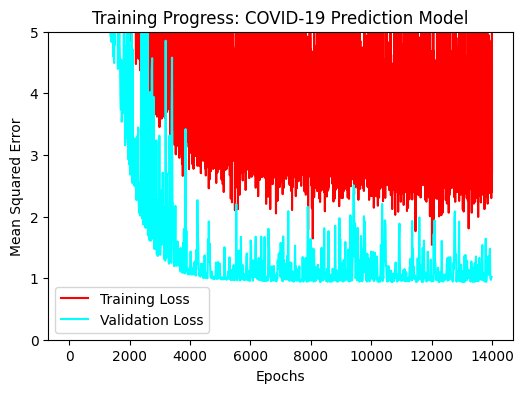

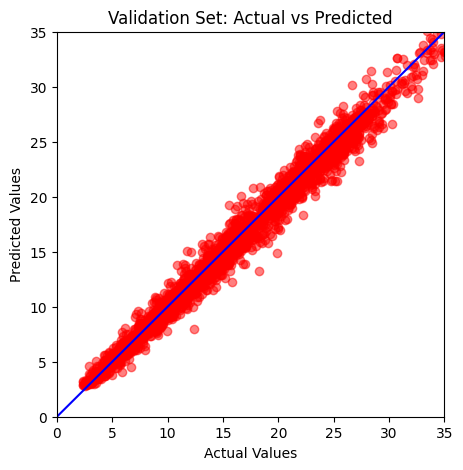

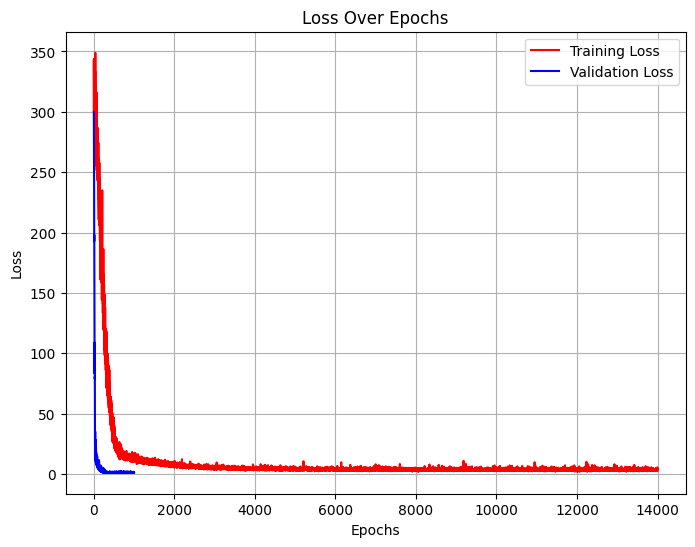

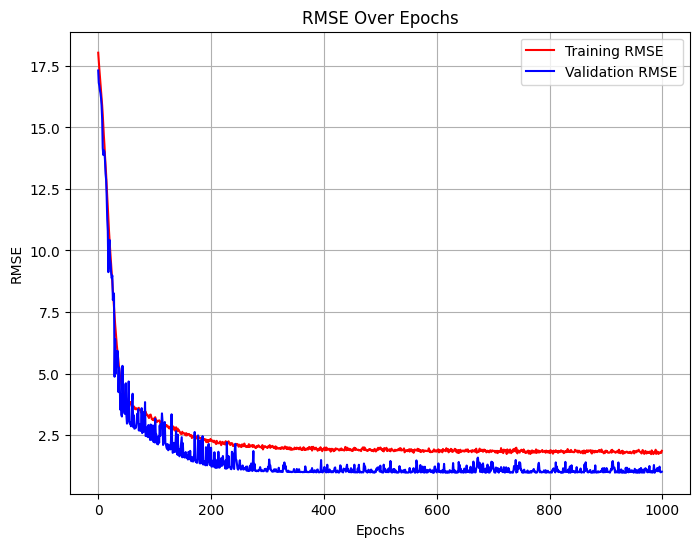

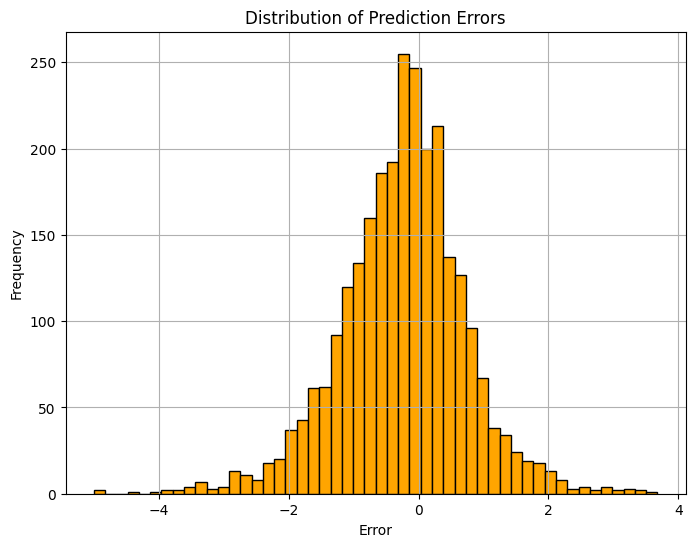

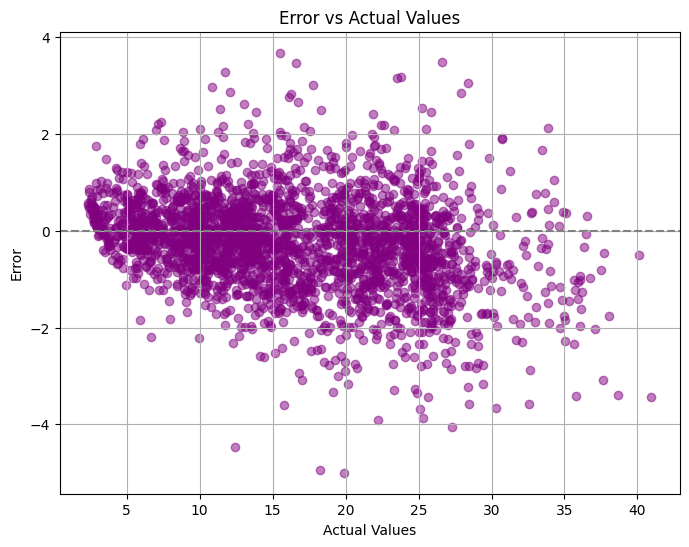

In [7]:
import os
import csv
import numpy as np
import torch
import matplotlib.pyplot as plt

from matplotlib.pyplot import figure

def determine_device():
    '''Choose the device for computations (GPU if available, otherwise CPU)'''
    return 'cuda' if torch.cuda.is_available() else 'cpu'

def save_predictions(predictions, filename):
    '''Save predictions to a CSV file'''
    print(f'Saving predictions to {filename}')
    with open(filename, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['id', 'tested_positive'])
        for i, pred in enumerate(predictions):
            writer.writerow([i, pred])

def main():
    # Configuration and data preparation
    device = determine_device()
    os.makedirs('models', exist_ok=True)
    target_only = True

    config = {
        'n_epochs': 1000,
        'batch_size': 200,
        'optimizer': 'Adam',
        'optim_hparas': {},
        'early_stop': 500,
        'save_path': 'models/best_model.pth'
    }

    train_loader = create_dataloader('/content/drive/MyDrive/covid.train.csv', 'train', config['batch_size'], features_only=True)
    val_loader = create_dataloader('/content/drive/MyDrive/covid.train.csv', 'dev', config['batch_size'], features_only=True)
    test_loader = create_dataloader('/content/drive/MyDrive/covid.test.csv', 'test', config['batch_size'], features_only=True)

    model = SimpleNN(train_loader.dataset.dimension).to(device)
    best_loss, loss_records, rmse_records = train_model(train_loader, val_loader, model, config, device)
    print(f'Best validation loss: {best_loss:.4f}')

    # Generate predictions
    preds = predict(test_loader, model, device)
    save_predictions(preds, 'pred.csv')

    # Plot the training progress
    plot_training_progress(loss_records, title='COVID-19 Prediction Model')

    # Plot predictions on the validation set
    plot_pred(val_loader, model, device)

    # Plot loss over epochs
    plot_loss_over_epochs(loss_records)

    # Plot RMSE over epochs
    plot_rmse_over_epochs(rmse_records)

    # Collect predictions and ground truths for error-related plots
    model.eval()
    all_predictions = []
    all_ground_truths = []

    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            predictions = model(data)
            all_predictions.append(predictions.cpu())
            all_ground_truths.append(target.cpu())

    all_predictions = torch.cat(all_predictions, dim=0).numpy()
    all_ground_truths = torch.cat(all_ground_truths, dim=0).numpy()


    # Plot prediction errors distribution
    plot_error_distribution(all_predictions, all_ground_truths)


    # Plot prediction errors vs actual values
    plot_error_vs_actual(all_predictions, all_ground_truths)

if __name__ == "__main__":
    main()
